# Analysis 2
- Outcome: ugica 
- Model: Individual log reg models for each subtype 
- Feature selection: Significant variables based on univariate analysis
- Predicts 5 year risk for combined UGI cancer outcome based on additive risk from subtype-specific models 
- Risk score threshold determined on 1) optimal threshold 

## Import libraries

In [1]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.stats import percentileofscore
from helpers.utils import generate_risk_percentile_df, classification_metrics

In [3]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [5]:
%%R
source("utils.R")
library(survival)

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Epi

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: rlang

R[write to console]: 
Attaching package: ‘rlang’


R[write to console]: The following object is masked from ‘package:magrittr’:

    set_names


R[write to consol

In [6]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [7]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")

In [8]:
risk_results_filename = './../results/risk_results_analysis_2_all_subtypes.csv'
json_filename = './../notebook/thresholds.json'
model = 'logreg'
subtypes = ['escc', 'eac', 'ncgc', 'cgc']

ro.globalenv['subtypes'] = list(subtypes)
ro.globalenv['subtypes'] = list(subtypes)

In [9]:
# Load the JSON file
with open(json_filename, "r") as f:
    model_variables = json.load(f)

## Import each subtype-specific model and the variables for each model

In [10]:
selected_vars = set()
for subtype in subtypes:
    model_vars = set(model_variables[model][subtype]['variables'])
    selected_vars.update(model_vars)
    print(subtype, model_vars)

ro.globalenv['selected_vars'] = list(selected_vars)
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS # + ['sex_clean'] # Needed to factorize categorical vars later

escc {'ethnicity', 'gerd', 'famhx_gastricca', 'hnca', 'tobacco_binary', 'famhx_colonca', 'alcohol_binary', 'famhx_cancer', 'PPI', 'age', 'cad', 'ASA', 'NSAID', 'pud'}
eac {'ethnicity', 'gerd', 'famhx_gastricca', 'hnca', 'race_clean', 'tobacco_binary', 'famhx_cancer', 'PPI', 'age', 'cad', 'sex_missing', 'pud'}
ncgc {'ethnicity', 'gerd', 'famhx_gastricca', 'hnca', 'race_clean', 'tobacco_binary', 'famhx_cancer', 'PPI', 'NSAID', 'age', 'cad', 'ASA', 'sex_missing', 'pud'}
cgc {'ethnicity', 'meets_eac_screening', 'gerd', 'famhx_gastricca', 'tobacco_binary', 'race_clean', 'famhx_cancer', 'PPI', 'NSAID', 'age', 'visit_year_bucket', 'cad', 'ASA', 'sex_missing', 'age_bucket', 'pud'}


In [11]:
for subtype in subtypes: 
    model_name = f'logreg_{subtype}.rds'
    ro.globalenv[f'logreg_{subtype}'] = model_name

## Factorize categorical vars and set reference levels

In [12]:
%%R
# Remove categorical variables that we do not want to include in analysis
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')

## Partition data

In [13]:
%%R 
unlist(selected_vars)

 [1] "ethnicity"           "meets_eac_screening" "gerd"               
 [4] "tobacco_binary"      "famhx_cancer"        "age"                
 [7] "cad"                 "visit_year_bucket"   "NSAID"              
[10] "sex_missing"         "age_bucket"          "famhx_gastricca"    
[13] "hnca"                "race_clean"          "famhx_colonca"      
[16] "alcohol_binary"      "PPI"                 "ASA"                
[19] "pud"                


In [14]:
%%R 
selected_vars <- unlist(selected_vars) # Convert from list to a character vector 

# Partition data
splits <- partition_data(r_df_normal, selected_vars, outcome = 'ugica', p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set


[1] "Dataset Controls 33871" "Dataset Cases 312"     
[1] "Training Controls 27103" "Training Cases 244"     
[1] "Validation Controls 6768" "Validation Cases 68"     



## Results

### Estimate risk for each subtype and add to get combined ugica risk

In [15]:
%%R 
# Get the outcomes in 1 year, 3 year and 5 year horizons
r_df_validation_risk <- generate_event_dataframe(validation_set)
risk_col_subtypes <- c() 

# Get the predicted risk 
for (subtype in subtypes) {
    # Load x model for that subtype 
    model_name <- paste0('logreg_', subtype, '.RDS')
    model <- readRDS(model_name)

    # Predict risk of that subtype
    risk_5_years <- calculate_risk_from_logreg(model, validation_set)

    # Save risk column
    risk_col_name <- paste0('pred_risk_', subtype)
    risk_col_subtypes <- c(risk_col_subtypes, risk_col_name)
    r_df_validation_risk[[risk_col_name]] <- risk_5_years
}

r_df_validation_risk$pred_risk_cum <- rowSums(r_df_validation_risk[, risk_col_subtypes])
names(r_df_validation_risk)

 [1] "time"              "event_ugica"       "event_escc"       
 [4] "event_eac"         "event_cgc"         "event_ncgc"       
 [7] "race"              "sex"               "age_bucket"       
[10] "visit_year_bucket" "ugica_5yr"         "escc_5yr"         
[13] "eac_5yr"           "cgc_5yr"           "ncgc_5yr"         
[16] "ugica_1yr"         "escc_1yr"          "eac_1yr"          
[19] "cgc_1yr"           "ncgc_1yr"          "ugica_3yr"        
[22] "escc_3yr"          "eac_3yr"           "cgc_3yr"          
[25] "ncgc_3yr"          "pred_risk_escc"    "pred_risk_eac"    
[28] "pred_risk_ncgc"    "pred_risk_cgc"     "pred_risk_cum"    


### Sensitivity and Metrics at 70% specificity

In [16]:
%%R 
# Convert variable from int to character before transfer to python
r_df_validation_risk[['race']] <- as.character(r_df_validation_risk[['race']])
r_df_validation_risk[['sex']] <- as.character(r_df_validation_risk[['sex']])
r_df_validation_risk[['age_bucket']] <- as.character(r_df_validation_risk[['age_bucket']])
r_df_validation_risk[['visit_year_bucket']] <- as.character(r_df_validation_risk[['visit_year_bucket']])

risk_5_years <- r_df_validation_risk$pred_risk_cum
event_5_years <- r_df_validation_risk$ugica_5yr

# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(risk_5_years, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)


Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.779 
Sensitivity: 0.675 
Specificity: 0.7021778 
PPV: 0.01316431 
NPV: 0.9972832 
NNS: 95.7168 
     predicted_class
event    0    1
    0 4772 2024
    1   13   27


### Sensitivity and Metrics at threshold that maximizes Youdens

In [17]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = event_5_years, predictor = risk_5_years)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(risk_5_years, event_5_years, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.779 
Sensitivity: 0.75 
Specificity: 0.6883461 
PPV: 0.01396648 
NPV: 0.9978669 
NNS: 84.50675 
     predicted_class
event    0    1
    0 4678 2118
    1   10   30


### AUROC curves and PR curve

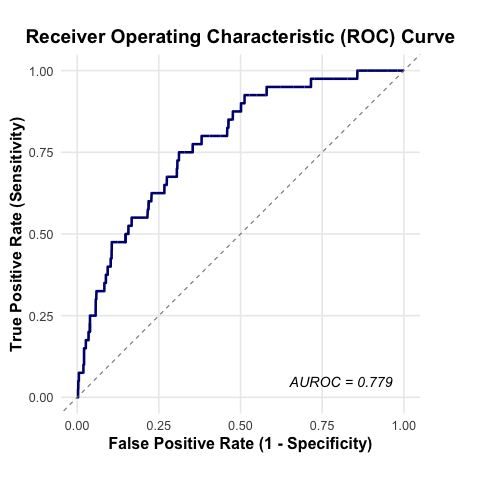

In [18]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)

p1

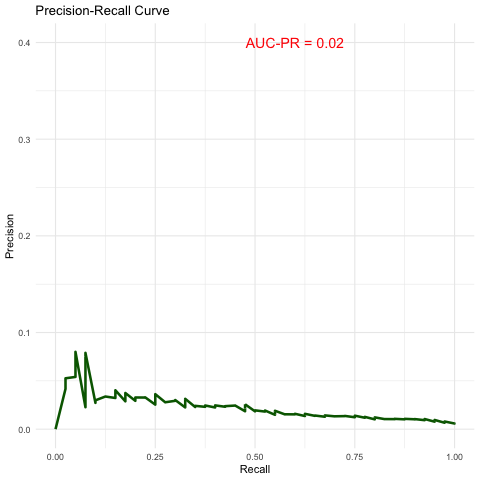

In [19]:
%%R
p2

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [20]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)
pred_risk = 'pred_risk_cum'
optimal_threshold = r['optimal_threshold'][0]
optimal_threshold_percentile = percentileofscore(df_validation_risk[pred_risk], optimal_threshold, kind='weak')/100.
percentile_cutoffs = [0, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1, optimal_threshold_percentile]

#Create different risk percentiles
df_validation_risk_percentile = generate_risk_percentile_df(df_validation_risk, pred_risk, percentile_cutoffs, optimal_threshold)

In [21]:
df_validation_risk.head()

,time,event_ugica,event_escc,event_eac,event_cgc,event_ncgc,race,sex,age_bucket,visit_year_bucket,ugica_5yr,escc_5yr,eac_5yr,cgc_5yr,ncgc_5yr,ugica_1yr,escc_1yr,eac_1yr,cgc_1yr,ncgc_1yr,ugica_3yr,escc_3yr,eac_3yr,cgc_3yr,ncgc_3yr,pred_risk_escc,pred_risk_eac,pred_risk_ncgc,pred_risk_cgc,pred_risk_cum,actual_percentile,risk_group,risk_p0.5,risk_p0.6,risk_p0.6857811585722645,risk_p0.7,risk_p0.75,risk_p0.8,risk_p0.85,risk_p0.9,risk_p0.95,risk_p0.975,risk_p0.99,risk_p1,high_risk,high_risk_youden
1,59.071869,0,0,0,0,0,No matching concept,MALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000102,0.000590,0.001302,0.000115,0.002108,0.246489,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.993840,0,0,0,0,0,No matching concept,FEMALE,60-69,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000119,0.000180,0.001197,0.000042,0.001539,0.145114,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,66.726899,0,0,0,0,0,White,MALE,40-49,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001364,0.007772,0.003365,0.001676,0.014176,0.940609,0.90,1,1,1,1,1,1,1,1,0,0,0,0,1,1
4,157.043121,0,0,0,0,0,No matching concept,FEMALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000479,0.000287,0.002372,0.000142,0.003280,0.444851,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.164271,0,0,0,0,0,White,MALE,70-79,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002895,0.006681,0.003597,0.005149,0.018322,0.971328,0.95,1,1,1,1,1,1,1,1,1,0,0,0,0,1


In [22]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
events_5yr = ['ugica_5yr', 'escc_5yr', 'eac_5yr', 'cgc_5yr', 'ncgc_5yr']
race_groups = df_validation_risk.race.unique()
age_groups = df_validation_risk.age_bucket.unique()
sex_groups = df_validation_risk.sex.unique()
visit_year_groups = df_validation_risk.visit_year_bucket.unique()

results_dataframe = []

# Get summary statistics for each risk percentile 
for risk_group in risk_groups:
    for event in events_5yr: 
        row = classification_metrics(df_validation_risk, risk_group, event)
        results_dataframe.append(row)

# Get summary statistics for each race 
for race in race_groups:
    df_risk_race = df_validation_risk[df_validation_risk.race == race]

    row = classification_metrics(df_risk_race, "high_risk_youden", 'ugica_5yr', race)
    results_dataframe.append(row)

# Get summary statistics for each sex 
for sex in sex_groups:
    df_risk_sex = df_validation_risk[df_validation_risk.sex == sex]

    row = classification_metrics(df_risk_sex, "high_risk_youden", 'ugica_5yr', sex)
    results_dataframe.append(row)

# Get summary statistics for each age
for age_bucket in age_groups:
    df_risk_age = df_validation_risk[df_validation_risk.age_bucket == age_bucket]

    row = classification_metrics(df_risk_age, "high_risk_youden", 'ugica_5yr', age_bucket)
    results_dataframe.append(row)

# Get summary statistics for visit year ranges
for visit_year_bucket in visit_year_groups:
    df_risk_visit_year = df_validation_risk[df_validation_risk.visit_year_bucket == visit_year_bucket]

    row = classification_metrics(df_risk_visit_year, "high_risk_youden", 'ugica_5yr', visit_year_bucket)
    results_dataframe.append(row)

df_results = pd.DataFrame(results_dataframe)

/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: Ru

#### Metrics for each percentile and cancer subtype, ordered by percentile

In [23]:
df_results.tail(5)

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
70,high_risk_youden,youden,ugica_5yr,70-79,1953,7,644,4 (0.6%),0.6,4,640,3,1313,0.671939,0.328061,57.142857,67.229903,0.621118,99.772036,254.352941,0.243728
71,high_risk_youden,youden,ugica_5yr,50-59,1262,9,376,7 (1.9%),1.9,7,369,2,893,0.708104,0.291896,77.777778,70.760697,1.861702,99.776536,61.041175,0.485385
72,high_risk_youden,youden,ugica_5yr,2011-2014,2857,11,922,8 (0.9%),0.9,8,914,3,1943,0.680265,0.319735,72.727273,68.008400,0.867679,99.845838,140.150914,0.407357
73,high_risk_youden,youden,ugica_5yr,2015-2018,2274,26,803,20 (2.5%),2.5,20,783,6,1491,0.656957,0.343043,76.923077,65.567282,2.490660,99.599198,47.850131,0.424904
74,high_risk_youden,youden,ugica_5yr,2019-2022,1665,3,423,2 (0.5%),0.5,2,421,1,1244,0.747002,0.252998,66.666667,74.714715,0.472813,99.919679,254.782293,0.413814


In [24]:
df_results.to_csv(risk_results_filename)

### Prevalance of cancer as a function of risk percentile by subtype

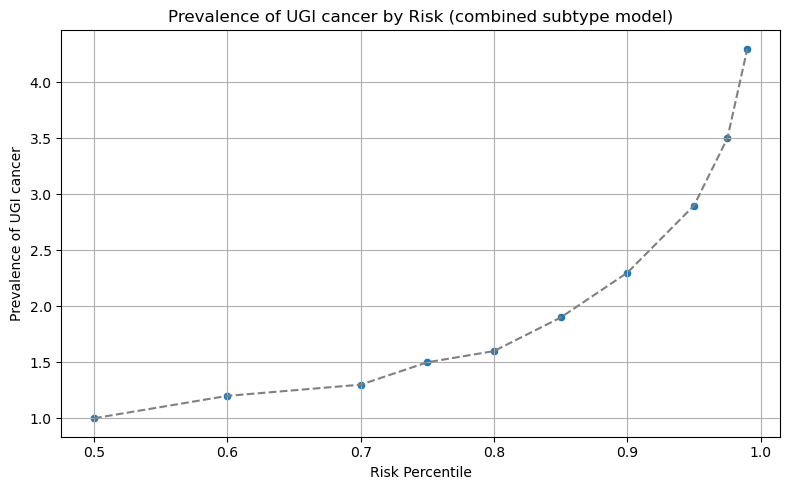

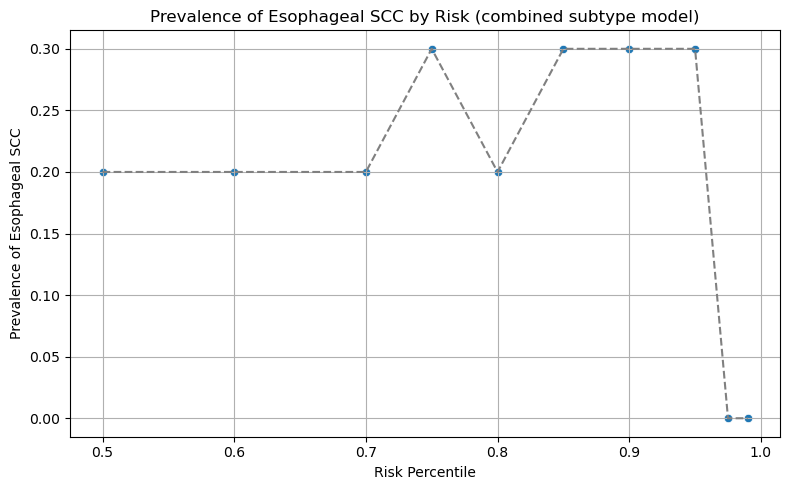

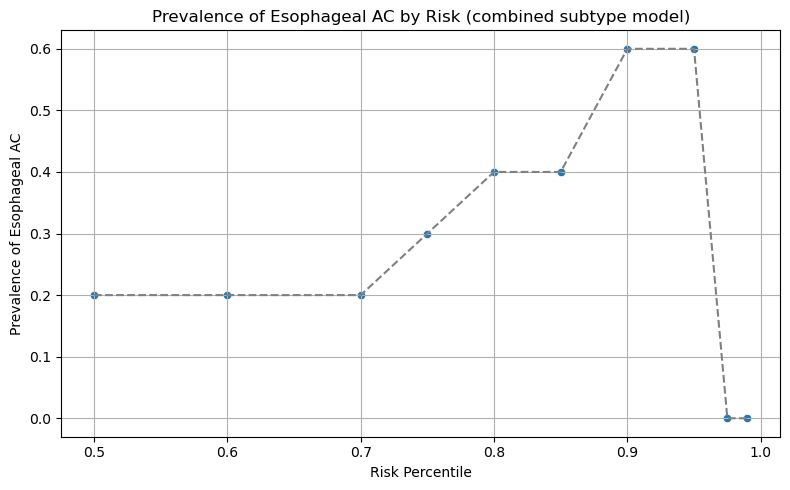

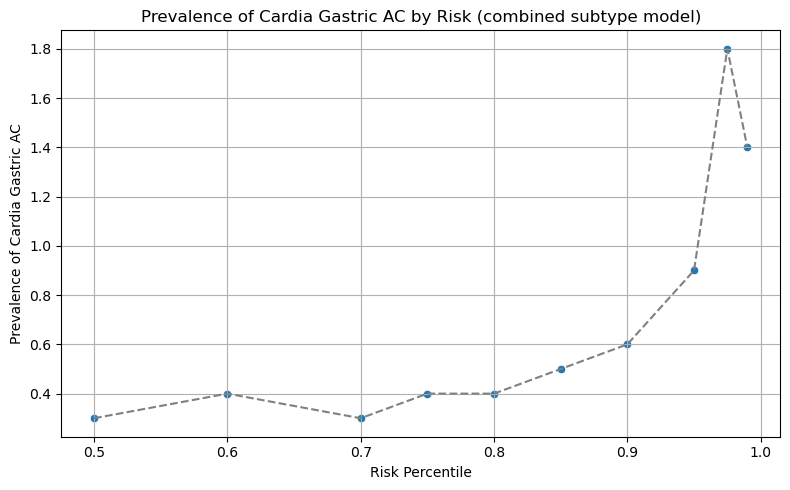

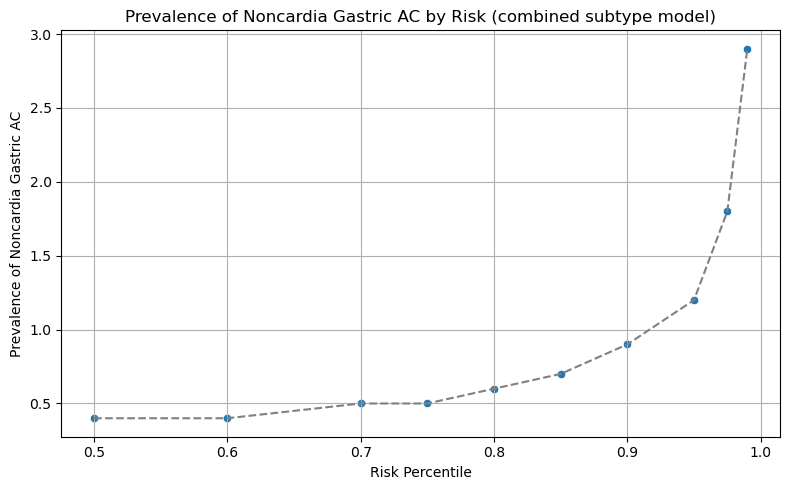

In [25]:
event_pretty_label = {
    "ugica_5yr": "UGI cancer", 
    "escc_5yr": "Esophageal SCC",
    "eac_5yr": "Esophageal AC",
    "cgc_5yr": "Cardia Gastric AC",
    "ncgc_5yr": "Noncardia Gastric AC"
}

df_results_plot = df_results[~df_results['risk_percentile'].isin(['youden', optimal_threshold_percentile])]

for event in events_5yr:
    # Plot the scatterplot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_results_plot[df_results_plot.event == event], x='risk_percentile', y='prevalence')

    # Optionally add a line to show trend
    sns.lineplot(data=df_results_plot[df_results_plot.event == event], x='risk_percentile', y='prevalence', color='gray', linestyle='--')

    plt.xlabel("Risk Percentile")
    #plt.xticks(ticks=range(len(percentile_cutoffs)-1), labels=percentile_cutoffs[1:])
    plt.ylabel(f'Prevalence of {event_pretty_label[event]}')
    plt.title(f'Prevalence of {event_pretty_label[event]} by Risk (combined subtype model)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Kaplan Meier survival curves stratified by risk group

In [26]:
pd.crosstab(df_validation_risk.ugica_5yr, df_validation_risk.high_risk_youden)

high_risk_youden,0,1
ugica_5yr,,
0.0,4678,2118
1.0,10,30


In [27]:
# Pass dataframe to R to analyze
ro.globalenv['r_df_validation_risk'] = df_validation_risk

/Users/alyssa.chen/miniconda3/envs/rpy2_env/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "risk_group". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


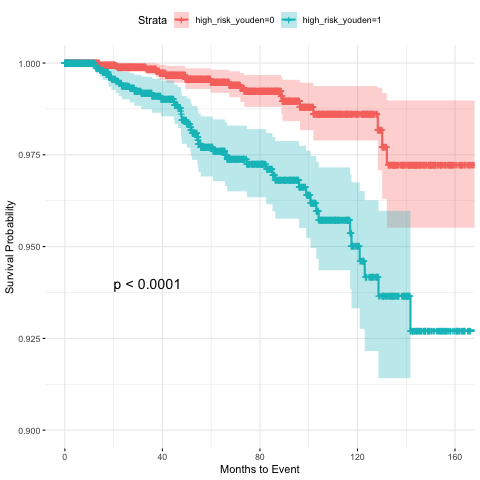

In [28]:
%%R 
surv_obj <- Surv(time = r_df_validation_risk$time, event = r_df_validation_risk$event_ugica)
fit <- survfit(surv_obj ~ high_risk_youden, data = r_df_validation_risk)

g <- ggsurvplot(
    fit,
    data = r_df_validation_risk,
    risk.table = TRUE,
    pval = TRUE,
    pval.coord = c(20, 0.94),
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = c(0.90, 1),
    ggtheme = theme_minimal()
)

g$plot